In [1]:
import pandas as pd
import numpy as np
import seaborn as sns  
import matplotlib.pyplot as plt
from datetime import date
from dateutil.relativedelta import relativedelta
import json
import time
%matplotlib inline 

# IMPORTANT:
# Redownload the files from slack and Outlook 

##### DATA (the anonymised dataframe) 

In [2]:
#import main dataframe
data = pd.read_csv('locations.csv', low_memory=False)

In [3]:
#rename City column and drop empty columns
data.rename( columns={'Unnamed: 5':'City'}, inplace=True )
data = data.drop(data.columns[data.columns.str.contains('unnamed',case = False)],axis = 1)

In [4]:
#drop VisitorID and ContentInfo
data = data.drop(columns=['VisitorID', 'ContentInfo'])

In [5]:
#just getting rid of the space after the name
data = data.replace('STH Ayshire St Leonards ', 'STH Ayshire St Leonards')
data.head()

,Time,ExternalID,Role,Building,City,LinkTitle,LinkType
0,29/10/2018 10:55,5325.0,User,Broom Ground,Stirling,Sam Smith,Internet
1,29/10/2018 10:50,5325.0,User,Broom Ground,Stirling,Elton John,Internet
2,29/10/2018 10:49,5325.0,User,Broom Ground,Stirling,My Music,Category
3,29/10/2018 10:49,5325.0,User,Broom Ground,Stirling,Entertainment,Category
4,29/10/2018 10:48,NaN,User,Belses Gardens - Care Home,Glasgow,BBC Formula 1,Internet


In [6]:
#change time to datetime
data['Time'] = pd.to_datetime(data['Time'], format = "%d/%m/%Y %H:%M", utc=False)

In [7]:
#change ExternalIDs to integers
data.ExternalID = data.ExternalID.fillna(0).astype(int)

In [8]:
#drop rows that are identical
data = data.drop_duplicates(keep='first')

In [9]:
#new dataframe with no null ExternalID vaues
data = data[data.ExternalID != 0]

In [10]:
data = data[(data.City != 'Test user ignore') & (data.City != 'test user')]

##### USERS (the user dataframe) 

In [11]:
#import users dataframe
users = pd.read_csv('PrimaryConditions age sex by customer reference.csv', low_memory=False)

In [12]:
users.shape

(695, 5)

In [13]:
#drop empty column and CleverCogsUserId
users = users.drop(users.columns[users.columns.str.contains('unnamed',case = False)],axis = 1)
users = users.drop(columns=['CleverCogsUserId'])

In [14]:
#delete empty row
users = users.dropna(axis=0, how='all', inplace=False)

In [15]:
#change ExternalID into integers
users['ExternalID'] = users['ExternalID'].apply(np.int64)
users.head()

,ExternalID,BirthDate,Gender,Condition
0,4703,04/07/1965,F,Spina Bifida
1,4704,21/06/1940,F,COPD
2,4706,25/02/1931,F,Dementia
3,4707,18/09/1982,F,Brain Injury
4,4708,20/12/1931,F,NaN


In [16]:
#drop duplicates
users = users.drop_duplicates(subset = ['ExternalID'], keep='last')
users.shape

(680, 4)

In [17]:
#change BirthDate to date time
#users['BirthDate'] = pd.to_datetime(users['BirthDate'], format = "%m/%d/%y", dayfirst=False, utc=True)

users['BirthDate'] = pd.to_datetime(users['BirthDate'], errors='coerce', dayfirst=False, yearfirst=False, 
                   format="%d/%m/%Y", utc=False, infer_datetime_format=False, origin='unix')
users = users.set_index(pd.DatetimeIndex(users['BirthDate']))

#Remove erroneous entries
threshold = pd.to_datetime("2010-01-01", format="%Y-%m-%d", utc=False, origin='unix')
users = users[users['BirthDate'] < threshold]

users.head()

,ExternalID,BirthDate,Gender,Condition
BirthDate,,,,
1965-07-04,4703,1965-07-04,F,Spina Bifida
1940-06-21,4704,1940-06-21,F,COPD
1931-02-25,4706,1931-02-25,F,Dementia
1982-09-18,4707,1982-09-18,F,Brain Injury
1931-12-20,4708,1931-12-20,F,NaN


In [18]:
now = pd.to_datetime(date.today())

def getYears(start):
    diff = relativedelta(now, start)
    return diff.years

# Add a new column that contains the age of the user
users["Age"] = users['BirthDate'].map(getYears)

In [19]:
users.head()
users.shape

(672, 5)

# Generate Network

This file will generate a JSON file that includes all LinkTitles as nodes, coloured by clusters of LinkTypes. 

```Node: id, label, numberOfTraffic, timeSpent```

The edges will represent each line of traffic. 

```Edge: id, label, userId, age bucket, startNodeId, endNodeId, date, time, prevDate, prevTime```


In [20]:
# Merge data and user on external id
data.ExternalID = (data.ExternalID.fillna(0)).astype(dtype='int64')
dataUserInner = pd.merge(data, users, on ="ExternalID", how="inner")


# create age buckets

def getAgeBucket(age):
    start = int(age/10)*10
    if age < start+5:
#         return (str(start) + '-' + str(start+5))
        return start
    else:
#         return (str(start+5) + '-' + str(start+10))
        return start+5


dataUserInner["AgeRange"] = dataUserInner['Age'].map(getAgeBucket)

# dataZero = dataUserInner[dataUserInner["ExternalID"] == 0]
# dataZero.head()

dataUserInner.head()


,Time,ExternalID,Role,Building,City,LinkTitle,LinkType,BirthDate,Gender,Condition,Age,AgeRange
0,2018-10-29 10:41:00,5541,User,STH Ayshire St Leonards,Ayr,YouTube,Internet,1954-02-18,M,Cerebral Palsy,64,60
1,2018-10-29 10:39:00,5541,User,STH Ayshire St Leonards,Ayr,YouTube,Internet,1954-02-18,M,Cerebral Palsy,64,60
2,2018-10-29 10:38:00,5541,User,STH Ayshire St Leonards,Ayr,YouTube,Internet,1954-02-18,M,Cerebral Palsy,64,60
3,2018-10-29 10:33:00,5541,User,STH Ayshire St Leonards,Ayr,YouTube,Internet,1954-02-18,M,Cerebral Palsy,64,60
4,2018-10-29 10:00:00,5541,User,STH Ayshire St Leonards,Ayr,YouTube,Internet,1954-02-18,M,Cerebral Palsy,64,60


In [21]:
# Sort by user to  allow linear processing
dataUserInner.sort_values(['ExternalID', 'Time'], ascending=[True, True], inplace=True)

In [24]:
dataUserInner.head()

,Time,ExternalID,Role,Building,City,LinkTitle,LinkType,BirthDate,Gender,Condition,Age,AgeRange
71133,2018-01-13 09:45:00,4703,User,Charleston,Dundee (Tayside),Keys To Life,Internet,1965-07-04,F,Spina Bifida,53,50
71134,2018-01-13 09:45:00,4703,User,Charleston,Dundee (Tayside),Health & Wellbeing,Category,1965-07-04,F,Spina Bifida,53,50
71135,2018-01-13 09:45:00,4703,User,Charleston,Dundee (Tayside),Information,Category,1965-07-04,F,Spina Bifida,53,50
71129,2018-01-20 20:29:00,4703,User,Charleston,Dundee (Tayside),Sudoku,Internet,1965-07-04,F,Spina Bifida,53,50
71130,2018-01-20 20:29:00,4703,User,Charleston,Dundee (Tayside),Single Player Games,Category,1965-07-04,F,Spina Bifida,53,50


In [70]:
# Iterate through file and process nodes and edges. Assign each distinct user a new id.

# Node: id, label, traffic, timeSpent, start, type
# Edge: id, label, userId, age bucket, startNodeId, endNodeId, timeDiff, pathId, end


# calculate timespent by adding the timediff to a time diff array at the node. Can then be used to 
# calculate averages or sum
links = {}

nodes = {}
edges = {}

threshold = 2 #hours
currentNodeId = 0
currentEdgeId = 0
currentUserId = 0
currentPathId = 0

prevUser = 0
prevTime = 0


node = {}
edge = {}
for index, row in dataUserInner.iterrows():
    # check if the same user
    if prevTime == 0: 
        prevTime = row.Time
    else: 
        timeDiff = row.Time - prevTime
        #print(timeDiff.total_seconds())
        
        
    if row.ExternalID != prevUser:
        if edge: 
            edge["end"] = True
            currentPathId+=1
        prevUser = row.ExternalID
        currentUserId += 1
    
    # check if time threshold
    elif timeDiff.total_seconds() > (2 * 60 * 60): 
        # start new path
        # check if previous edge needs finishing
        if edge: 
            edge["end"] = True
            currentPathId+=1
    

    # set up new start node and edge
    # check if this link already in node
    nodeId = 0
    nodeTraffic = 0
    if row.LinkTitle in links: 
        # this node already exists and if so update it with the traffic
        nodeId, nodeTraffic = links[row.LinkTitle]
        links[row.LinkTitle] = (nodeId, nodeTraffic+1)
        nodes[nodeId]["traffic"] = nodeTraffic+1
    else: 
        #create new node
        nodeId = currentNodeId
        currentNodeId+=1
        node = {"id":nodeId, "label": row.LinkTitle, "traffic":1, "type": row.LinkType, "timeDiffs": []}
        links[row.LinkTitle] = (nodeId, 1)
        nodes[nodeId] = node
    
    if edge: 
        edge["timeDiff"] = timeDiff.total_seconds()
        edge["endNode"] = nodeId
        edges[currentEdgeId] = edge
        nodes[edge["startNode"]]["timeDiffs"].append(timeDiff.total_seconds())
        currentEdgeId += 1
        edge = {}

    #create edge
    prevTime = row.Time
    edge = {"id": currentEdgeId, "userId":currentUserId, "age": row.AgeRange, 
             "startNode": nodeId, "pathId": currentPathId}
    node = {}


In [71]:
nodesList = []
edgesList = []

for key, value in nodes.items():
    nodesList.append(value)

for key, value in edges.items(): 
    edgesList.append(value)

In [72]:
# difference in seconds (b-a).total_seconds()

# for i in range(0,10):
#     print(nodes[i])
    

# for i in range(0,30):
#     print(edges[i])

#print(edges[500])
    
print("node: "),
print(nodesList[0])

print("edges: "),
print(edgesList[0])
    
print(len(nodes))
print(len(edges))

node: 
{'id': 0, 'label': 'Keys To Life', 'traffic': 22, 'type': 'Internet', 'timeDiffs': [0.0, 60.0, 960.0, 0.0, 60.0, 604740.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 420.0, 60.0, 480.0, 120.0]}
edges: 
{'id': 0, 'userId': 1, 'age': 50, 'startNode': 0, 'pathId': 0, 'timeDiff': 0.0, 'endNode': 1}
478
71731


In [73]:
edgesJson = json.dumps(edgesList)
nodesJson = json.dumps(nodesList)
graph = {"links": edges, "nodes": nodes}

In [74]:
with open('nodes.json', 'w') as outfile:
    json.dump(nodesJson, outfile)
    

In [75]:
with open('edges.json', 'w') as outfile:
    json.dump(edgesJson, outfile)

In [76]:
with open('graph.json', 'w') as outfile:
    json.dump(graph, outfile)

In [77]:
# #Iterate through file and process nodes and edges. Assign each distinct user a new id.

# #Node: id, label, traffic, timeSpent, start, type
# #Edge: id, label, userId, age bucket, startNodeId, endNodeId, timeDiff, pathId, end


# #calculate timespent by adding the timediff to a time diff array at the node. Can then be used to 
# #calculate averages or sum
# links = {}

# nodes = {}
# edges = {}

# threshold = 2 #hours
# currentNodeId = 0
# currentEdgeId = 0
# currentUserId = 0
# currentPathId = 0

# prevUser = 0
# prevTime = 0


# node = {}
# edge = {}
# for index, row in dataUserInner.iterrows():
#     # check if the same user
#     if prevTime == 0: 
#         prevTime = row.Time
#     else: 
#         timeDiff = row.Time - prevTime
#         #print(timeDiff.total_seconds())
        
#     if row.ExternalID != prevUser:
#         if edge: 
#             edge["end"] = True
#             currentPathId+=1
#         prevUser = row.ExternalID
#         currentUserId += 1
    
#     # check if time threshold
#     elif timeDiff.total_seconds() > (2 * 60 * 60): 
#         # start new path
#         # check if previous edge needs finishing
#         if edge: 
#             edge["end"] = True
#             currentPathId+=1
    

#     # set up new start node and edge
#     # check if this link already in node
#     nodeLabel = row.LinkTitle
#     nodeTraffic = 0
#     if row.LinkTitle in links: 
#         # this node already exists and if so update it with the traffic
#         links[nodeLabel] +=1
#         nodeTraffic = links[nodeLabel]
#         nodes[nodeLabel]["traffic"] = nodeTraffic
#     else: 
#         #create new node
#         node = {"label": row.LinkTitle, "traffic":1, "type": row.LinkType, "timeDiffs": []}
#         links[nodeLabel] = 1
#         nodes[nodeLabel] = node
    
#     if edge: 
#         edge["timeDiff"] = timeDiff.total_seconds()
#         edge["endNode"] = nodeLabel
#         edges[currentEdgeId] = edge
#         nodes[edge["startNode"]]["timeDiffs"].append(timeDiff.total_seconds())
#         currentEdgeId += 1
#         edge = {}

#     #create edge
#     prevTime = row.Time
#     edge = {"id": currentEdgeId, "userId":currentUserId, "age": row.AgeRange, 
#              "startNode": nodeLabel, "pathId": currentPathId}
#     node = {}


In [78]:
for i in range(0,10):
    print(edges[i])
    
print(len(nodes))



{'id': 0, 'userId': 1, 'age': 50, 'startNode': 0, 'pathId': 0, 'timeDiff': 0.0, 'endNode': 1}
{'id': 1, 'userId': 1, 'age': 50, 'startNode': 1, 'pathId': 0, 'timeDiff': 0.0, 'endNode': 2}
{'id': 2, 'userId': 1, 'age': 50, 'startNode': 2, 'pathId': 0, 'end': True, 'timeDiff': 643440.0, 'endNode': 3}
{'id': 3, 'userId': 1, 'age': 50, 'startNode': 3, 'pathId': 1, 'timeDiff': 0.0, 'endNode': 4}
{'id': 4, 'userId': 1, 'age': 50, 'startNode': 4, 'pathId': 1, 'timeDiff': 0.0, 'endNode': 5}
{'id': 5, 'userId': 1, 'age': 50, 'startNode': 5, 'pathId': 1, 'timeDiff': 0.0, 'endNode': 6}
{'id': 6, 'userId': 1, 'age': 50, 'startNode': 6, 'pathId': 1, 'timeDiff': 240.0, 'endNode': 7}
{'id': 7, 'userId': 1, 'age': 50, 'startNode': 7, 'pathId': 1, 'timeDiff': 60.0, 'endNode': 8}
{'id': 8, 'userId': 1, 'age': 50, 'startNode': 8, 'pathId': 1, 'end': True, 'timeDiff': 208140.0, 'endNode': 9}
{'id': 9, 'userId': 1, 'age': 50, 'startNode': 9, 'pathId': 2, 'timeDiff': 0.0, 'endNode': 4}
478


In [33]:
# nList = []
# eList = []
# ed = {}
# allnodes=[]

# for key, value in nodes.items():
#     if value["traffic"] > 50:
#         nList.append({"id": value["label"], "group": value["type"], "traffic": value["traffic"]})
#         allnodes.append(value["label"])

# for key, value in edges.items():
#     if value["timeDiff"] > 2*60*60 and (value["startNode"] in allnodes) and (value["endNode"] in allnodes):
#         ekey = str(value["startNode"]) + "_" + str(value["endNode"])
#         if ekey in ed:
#             ed[ekey] +=1
#         else:
#             ed[ekey] = 1
#     else: 
#         continue
    
# for key, value in ed.items():
#     start, end = key.split("_")
#     eList.append({"source": start, "target": end, "value": value})

In [91]:
nList = []
eList = []
ed = {}
allnodes={}

currentId = 0
for key, value in nodes.items():
    if value["traffic"] > 50:
        nList.append({"id": currentId, 'label': value["label"], "group": value["type"], "traffic": value["traffic"]})
        allnodes[value["id"]] = currentId
        currentId +=1

for key, value in edges.items():
    if value["timeDiff"] > 2*60*60 and (value["startNode"] in allnodes) and (value["endNode"] in allnodes):
        ekey = str(value["startNode"]) + "_" + str(value["endNode"])
        if ekey in ed:
            ed[ekey] +=1
        else:
            ed[ekey] = 1
    else: 
        continue
        
tracked =[]
currentId = 0
for key, value in edges.items(): 
    if value["timeDiff"] > 2*60*60 and (value["startNode"] in allnodes) and (value["endNode"] in allnodes):
        ekey = str(value["startNode"]) + "_" + str(value["endNode"])
        if ekey in ed and ekey not in tracked: 
            eList.append({"id": currentId, "source": allnodes[value["startNode"]], 
                          "target": allnodes[value["endNode"]],
                         'value': ed[ekey]})
            currentId+=1
            tracked.append(ekey)
        
    
# for key, value in ed.items():
#     start, end = key.split("_")
#     eList.append({"source": start, "target": end, "value": value})

In [92]:

for i in range(0,10):
    print(eList[i])

types = set()
for i in range(0,10):
    types.add(nList[i]["group"])
    print(nList[i])
    
print(len(eList))
print(len(nList))
print(len(ed))

print(types)


{'id': 0, 'source': 9, 'target': 8, 'value': 1}
{'id': 1, 'source': 8, 'target': 4, 'value': 1}
{'id': 2, 'source': 4, 'target': 7, 'value': 39}
{'id': 3, 'source': 7, 'target': 4, 'value': 26}
{'id': 4, 'source': 4, 'target': 5, 'value': 7}
{'id': 5, 'source': 9, 'target': 2, 'value': 2}
{'id': 6, 'source': 1, 'target': 10, 'value': 2}
{'id': 7, 'source': 16, 'target': 4, 'value': 5}
{'id': 8, 'source': 4, 'target': 8, 'value': 9}
{'id': 9, 'source': 9, 'target': 1, 'value': 1}
{'id': 0, 'label': 'Health & Wellbeing ', 'group': 'Category', 'traffic': 115}
{'id': 1, 'label': 'Information', 'group': 'Category', 'traffic': 835}
{'id': 2, 'label': 'Single Player Games', 'group': 'Category', 'traffic': 3879}
{'id': 3, 'label': 'Play Games', 'group': 'Category', 'traffic': 3887}
{'id': 4, 'label': 'Entertainment', 'group': 'Category', 'traffic': 10078}
{'id': 5, 'label': 'Mini Golf', 'group': 'Internet', 'traffic': 97}
{'id': 6, 'label': 'Family & Friends', 'group': 'Internet', 'traffic': 3

In [93]:
# note neighbours and connected links

neighbouring = {}
# all neighbours of each node
for value in eList:
    source = value['source']
    if source in neighbouring:
        neighbouring[source]['neighbours'].append(value['target'])
        neighbouring[source]['outgoing'].append(value['id'])
    else: 
        neighbouring[source] = {'neighbours':[value['target']], 'outgoing': [value['id']]}
            
#print(neighbouring)

        


In [94]:
# i = 0
# for key, item in neighbours.items():
#     if i > 10:
#         break
#     else:
#         print(key, item)

# i = 0
# for key, item in outgoingLinks.items():
#     if i > 10:
#         break
#     else:
#         print(key, item)

#print(neighbouring)

{9: {'neighbours': [8, 2, 1, 42, 29, 15, 53, 9, 10, 50, 4, 3, 56, 34, 11], 'outgoing': [0, 5, 9, 193, 233, 235, 236, 237, 239, 240, 242, 256, 268, 349, 686]}, 8: {'neighbours': [4, 29, 15, 42, 34, 11, 66, 38], 'outgoing': [1, 60, 321, 333, 337, 355, 390, 409]}, 4: {'neighbours': [7, 5, 8, 21, 18, 19, 4, 9, 13, 23, 1, 15, 26, 14, 29, 42, 43, 41, 45, 44, 2, 46, 22, 36, 6, 49, 32, 10, 55, 53, 52, 40, 50, 3, 39, 61, 57, 58, 63, 34, 64, 17, 11, 38, 65, 66, 68, 69, 33, 56, 59, 70, 72, 71, 74, 16, 73, 20, 25, 75, 67, 76, 31, 27, 30, 51, 47, 24, 28, 79, 54], 'outgoing': [2, 4, 8, 16, 24, 28, 31, 38, 39, 40, 42, 44, 45, 55, 56, 80, 94, 102, 108, 116, 127, 130, 152, 158, 159, 163, 189, 197, 212, 216, 219, 244, 251, 264, 275, 287, 293, 295, 304, 326, 343, 352, 353, 367, 373, 395, 408, 428, 429, 431, 435, 438, 493, 498, 499, 504, 508, 519, 546, 555, 567, 582, 614, 625, 637, 639, 663, 678, 707, 718, 733]}, 7: {'neighbours': [4, 1, 15, 6, 37, 7, 43, 42, 46, 44, 0, 36, 41, 49, 29, 51, 22, 10, 35, 52,

In [95]:
with open('graph-basic.json', 'w') as outfile:
    json.dump({"links": eList, "nodes": nList, 'neighbouring': neighbouring}, outfile)

# More Graphs


In [38]:

data['Time'] = pd.to_datetime(data['Time'], errors='coerce', dayfirst=False, yearfirst=False, 
                   format=None, utc=False, infer_datetime_format=True, origin='unix')
data = data.set_index(pd.DatetimeIndex(data['Time']))

Average per month:  8798.2
Average per day:  291.33112582781456


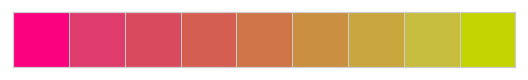

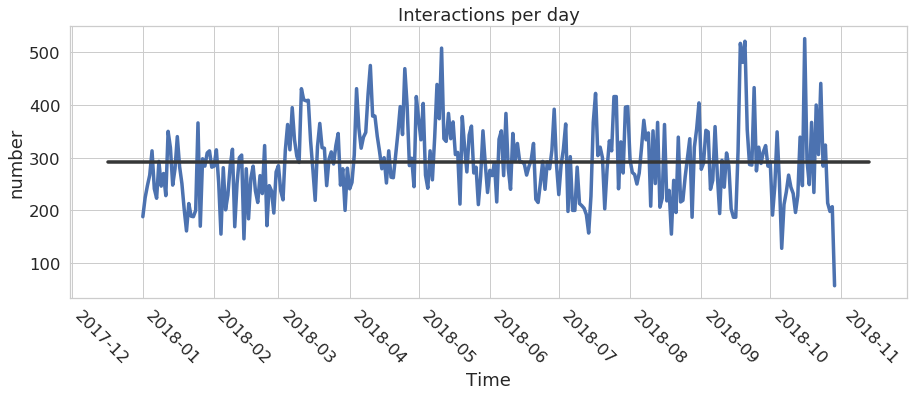

<Figure size 432x288 with 0 Axes>

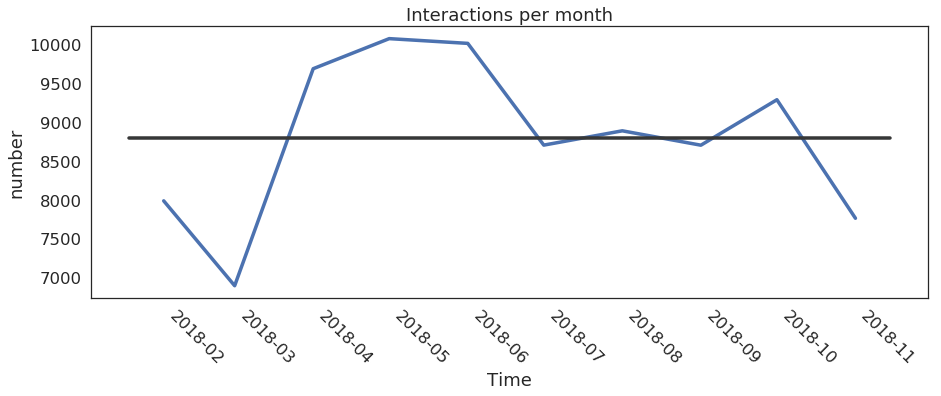

<Figure size 432x288 with 0 Axes>

In [64]:
data = data[data['ExternalID'].notna()]
month = data['Time'].resample('M').count().reset_index(name="number")
mav = month['number'].mean()
print('Average per month: ', mav )

day = data['Time'].resample('D').count().reset_index(name="number")
dav = day['number'].mean()
print('Average per day: ', dav)

flatui = ["#Fb007F", "#df3b6d", "#da4a5f", "#d55e53", "#d07548", "#cb8f41", "#c9a73e", "#c7be3f", "#c3d400"]
sns.palplot(sns.color_palette(flatui))

fig, ax = plt.subplots()
fig.set_size_inches(15, 5)

sns.lineplot(x="Time", y="number", data=day, legend="full")
plt.xticks(rotation=-45, ha='left')
plt.title("Interactions per day")
sns.set_style("white")
x = plt.gca().axes.get_xlim()
plt.plot(x, len(x) * [dav], sns.xkcd_rgb["dark grey"])
plt.show()
plt.savefig("fig1.svg")

fig, ax = plt.subplots()
fig.set_size_inches(15, 5)
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 3.5})
sns.lineplot(x="Time", y="number", data=month, legend="full")
sns.set_style("whitegrid")
sns.color_palette(flatui)
plt.xticks(rotation=-45, ha='left')
plt.title("Interactions per month")
x = plt.gca().axes.get_xlim()
plt.plot(x, len(x) * [mav], sns.xkcd_rgb["dark grey"])
plt.show()
plt.savefig("fig2.svg")

    daytime  number
0  00:00:00    2527
1  01:00:00    1329
2  02:00:00    1090
3  03:00:00    1307
4  04:00:00     937


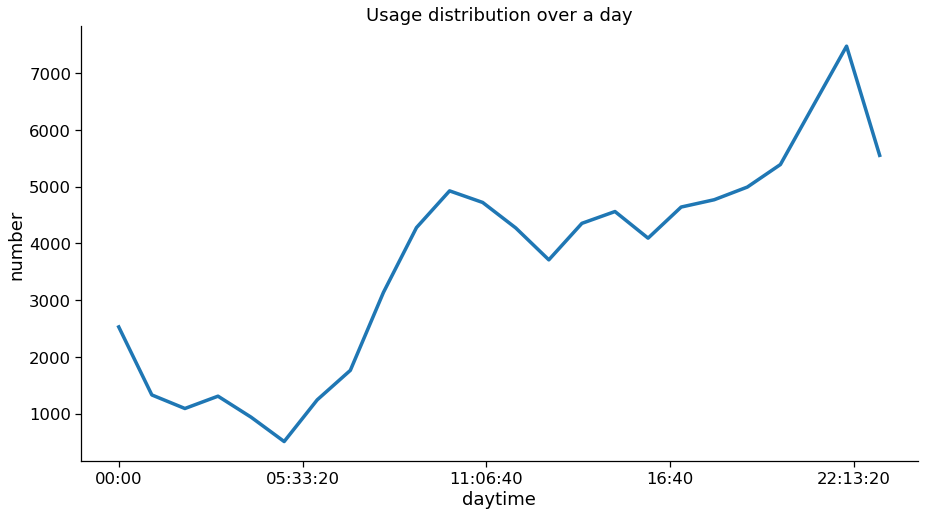

In [22]:
daytimes = (data.Time.map(lambda t: t.replace(year=2013, month=2, day=1))).reset_index(name="daytime")
daytimes['daytime'] = pd.to_datetime(daytimes['daytime'], errors='coerce', dayfirst=False, yearfirst=False, 
                   format=None, utc=False, infer_datetime_format=True, origin='unix')
daytimes = daytimes.set_index(pd.DatetimeIndex(daytimes['daytime']))

# count interaction per hour
daytimes = daytimes['daytime'].resample('H').count().reset_index(name="number")
daytimes['daytime'] = daytimes[daytimes['daytime'].notnull()]['daytime'].dt.time

print(daytimes.head())

sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 3.5})
fig, ax = plt.subplots()
fig.set_size_inches(15, 8)
sns.lineplot(x="daytime", y="number", data=daytimes, ax = ax)
sns.set_style("white")
sns.despine()
plt.title("Usage distribution over a day")
plt.savefig("fig3.svg")

In [35]:
times = dataUserInner.filter(['Time', 'Age','ExternalID', 'Gender', 'Condition'], axis=1)
times = times[(times.Gender == 'F') | (times.Gender == 'M')]
times['Time'] = (times.Time.map(lambda t: t.replace(year=2013, month=1, day=1)))
times = times.set_index(pd.DatetimeIndex(times['Time']))
times.head()

# There must be a better way to do it, however, after hours of googling, I am going
# to do it the iterative way. 'Premature optimization is the root of all evil' -- DonaldKnuth

# Don't worry, this part runs for at least 30s. 

# Create the buckets
dates = pd.date_range('1/1/2013', periods=24, freq='H')
buckets = sorted(set(zip(list(range(0,24)), dates)))

# Iterate over the time and assign buckets for each time of day

def getBucket(time):
    for bucket in buckets: 
        diff = relativedelta(time, bucket[1])
        if diff.hours == 0 and diff.minutes <= 60:
            #print(diff.minutes)
            # return (str(bucket[0]) + '-'+ str(bucket[0]+1))
            return bucket[0]
#     return (str(bucket[-1][0]) + '-'+ str(bucket[-1][0]+1)) 
    return bucket[-1][0]
    

times["Times"] = times['Time'].map(getBucket)

In [45]:
genderGrouped = times.groupby(['Hours', 'Gender'])["ExternalID"].count().reset_index(name="Count").sort_values(by=['Hours'])
nonGrouped = times.groupby(['Hours'])["ExternalID"].count().reset_index(name="Count").sort_values(by=['Hours'])
nonGrouped['Gender'] = 'B'

   Hours Gender  Count
0      0      F   2030
1      0      M    276
2      1      F    868
3      1      M    226
4      2      F    370
   Hours  Count Gender
0      0   2306      B
1      1   1094      B
2      2    549      B
3      3    320      B
4      4    420      B
   Count Gender  Hours
0   2306      B      0
1   1094      B      1
2    549      B      2
3    320      B      3
4    420      B      4


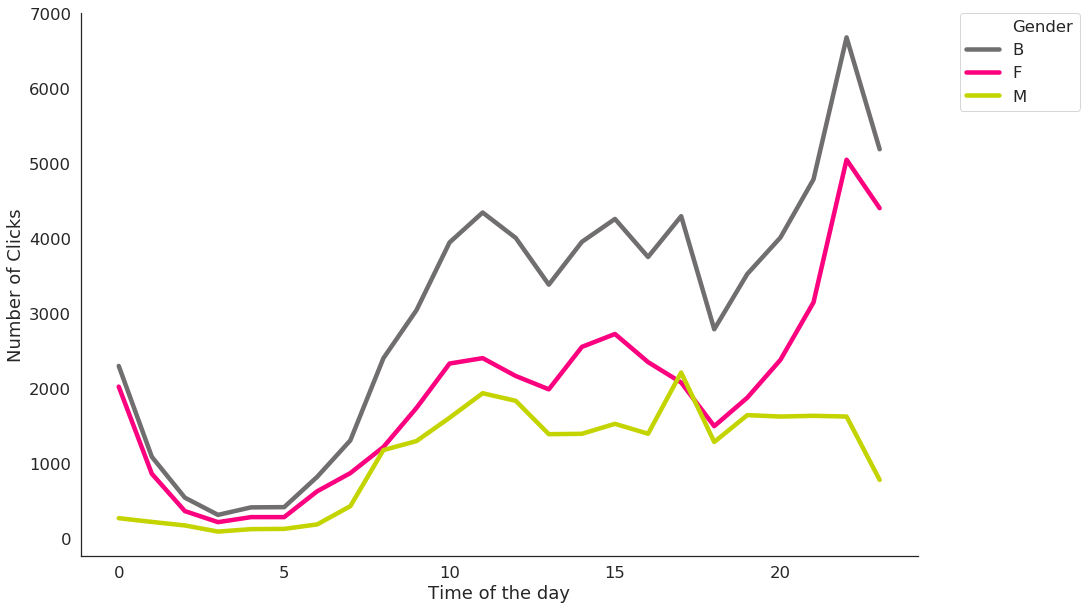

In [52]:
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 4.5})

print(genderGrouped.head())
print(nonGrouped.head())

allGrouped = pd.concat([nonGrouped, genderGrouped],sort=True)

print(allGrouped.head())

flatui = [ '#706e6f',"#Fb007F", "#c3d400"]

fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
sns.lineplot(x='Hours', y='Count', data=allGrouped, hue='Gender', palette=flatui)
sns.despine()
sns.set_style("white")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set(xlabel='Time of the day', ylabel='Number of Clicks')
plt.savefig("GenderUsage.svg", format="svg")
plt.show()
